## Reddit data-set for sarcasm detection (pt 1)

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

## Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.05) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

50539
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

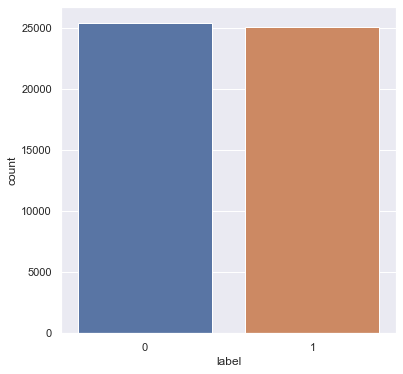

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

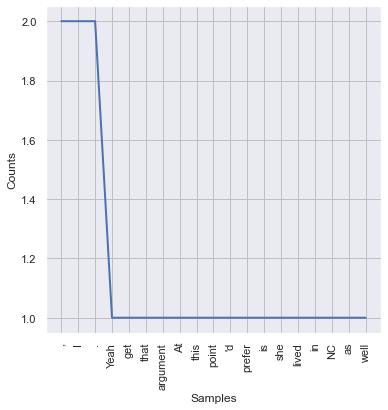

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'about', 'at', 'during', 'on', 'were', 'when', 'needn', 'against', "mightn't", 'weren', 'was', 'didn', "it's", 'from', 'by', 'him', 'too', 'd', 'these', 'will', 'over', 'then', 'other', 'have', 'hadn', "you've", 'her', "needn't", "you'd", 'such', "shan't", 'only', 'doesn', 'each', 'once', 'shan', 'himself', 'yourself', 'you', 'do', 'its', 'off', 'of', 'am', 'ourselves', 'a', 'some', 've', 'who', 're', 'more', 'whom', 'wasn', 'hers', 'did', 'few', 'does', 'there', 'than', "haven't", 'those', 'to', 'themselves', 'under', 'now', 'yours', 'as', 's', "wasn't", 'wouldn', 'where', 'same', 'itself', 'my', 'very', 'how', 'been', 'no', 'this', 'yourselves', 'own', 'don', 'because', 'here', 'nor', "hasn't", 'i', 'can', 'if', 'ma', 'should', 'them', 'couldn', 'up', 'isn', "shouldn't", 'herself', 'being', 'further', 'not', 'hasn', 'we', "she's", 'while', 'but', 'mustn', 'above', "aren't", 'they', 'had', 'both', "don't", 'has', 'which', "hadn't", "won't", 'me', 'just', 't', "couldn't", "mustn't", "

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

### Dpendency parser

In [29]:
nlp = spacy.load("en_core_web_sm")

In [30]:
from spacy import displacy

In [31]:
s_example = nlp(example)

In [32]:
displacy.render(s_example, style='dep')

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

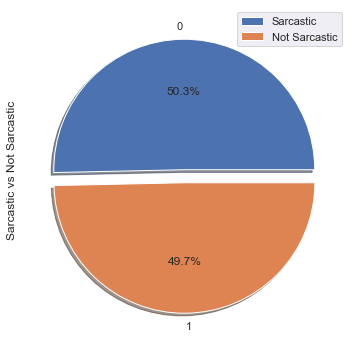

In [33]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [34]:
## Number of unique comment author
red_sample['author'].nunique()

42015

In [35]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

4068

In [36]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [37]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,---,0,1
1,--------__--------,0,1
2,--------__--------,1,2
3,---Earth---,1,1
4,--4-8-15-16-23-42,0,1
...,...,...,...
45912,zzt711,1,1
45913,zzthex,1,1
45914,zzyyxxqq,0,1
45915,zzzev,0,1


In [38]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
---,0
--------__--------,2
---Earth---,1
--4-8-15-16-23-42,0
--Kai--,1
...,...
zzt711,1
zzthex,1
zzyyxxqq,0


In [39]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,---,1
1,--------__--------,3
2,---Earth---,1
3,--4-8-15-16-23-42,1
4,--Kai--,1
...,...,...
42010,zzt711,1
42011,zzthex,1
42012,zzyyxxqq,1
42013,zzzev,1


In [40]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,---,0,1
1,--------__--------,2,3
2,---Earth---,1,1
3,--4-8-15-16-23-42,0,1
4,--Kai--,1,1
...,...,...,...
42010,zzt711,1,1
42011,zzthex,1,1
42012,zzyyxxqq,0,1
42013,zzzev,0,1


In [41]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,---,0,1,0.000000
1,--------__--------,2,3,0.666667
2,---Earth---,1,1,1.000000
3,--4-8-15-16-23-42,0,1,0.000000
4,--Kai--,1,1,1.000000
...,...,...,...,...
42010,zzt711,1,1,1.000000
42011,zzthex,1,1,1.000000
42012,zzyyxxqq,0,1,0.000000
42013,zzzev,0,1,0.000000


In [42]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [43]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,112263Hulu,0,1
1,11bx1371,0,1
2,12Monkeys,0,1
3,1911,0,1
4,195,0,1
...,...,...,...
5746,zenfone2,0,1
5747,zeroescapecirclejerk,0,1
5748,zombies,0,1
5749,zootopia,1,1


In [44]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
112263Hulu,0
11bx1371,0
12Monkeys,0
1911,0
195,0
...,...
zenfone2,0
zeroescapecirclejerk,0
zombies,0


In [45]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,112263Hulu,1
1,11bx1371,1
2,12Monkeys,1
3,1911,1
4,195,1
...,...,...
4063,zenfone2,1
4064,zeroescapecirclejerk,1
4065,zombies,1
4066,zootopia,1


In [46]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,112263Hulu,0,1
1,11bx1371,0,1
2,12Monkeys,0,1
3,1911,0,1
4,195,0,1
...,...,...,...
4063,zenfone2,0,1
4064,zeroescapecirclejerk,0,1
4065,zombies,0,1
4066,zootopia,1,1


In [47]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,112263Hulu,0,1,0.0
1,11bx1371,0,1,0.0
2,12Monkeys,0,1,0.0
3,1911,0,1,0.0
4,195,0,1,0.0
...,...,...,...,...
4063,zenfone2,0,1,0.0
4064,zeroescapecirclejerk,0,1,0.0
4065,zombies,0,1,0.0
4066,zootopia,1,1,1.0


In [48]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [49]:
subreddits = red_sample['subreddit'].value_counts()

In [50]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,3244
politics,2021
worldnews,1237
leagueoflegends,1022
pcmasterrace,896
...,...
lol,1
gnome,1
Iraq,1
bunburyfestival,1


In [51]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [52]:
top_ten['sub'] = top_ten.index

In [53]:
top_ten

,subreddit,sub
AskReddit,3244,AskReddit
politics,2021,politics
worldnews,1237,worldnews
leagueoflegends,1022,leagueoflegends
pcmasterrace,896,pcmasterrace
funny,857,funny
pics,809,pics
news,795,news
GlobalOffensive,710,GlobalOffensive
nfl,707,nfl


In [54]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,3244,AskReddit
1,2021,politics
2,1237,worldnews
3,1022,leagueoflegends
4,896,pcmasterrace
5,857,funny
6,809,pics
7,795,news
8,710,GlobalOffensive
9,707,nfl


In [55]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [56]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
263847,1,"""Well, that was long ago, we're talking about ...",ShyBiDude89,politics,2,2,0,2016-06,2016-06-17 00:20:27,More like 200-300 years ago during The Enlight...
338607,1,yeah... but the economy,Bowflex_Jesus,pics,1,1,0,2016-08,2016-08-09 02:58:43,Abandoned Olympic Venues from around the world.
832403,1,Yeah we all remeber those water pistols with a...,xNeptune,GlobalOffensive,12,12,0,2014-12,2014-12-24 13:43:15,Lol if anything is a water pistol it's the M4 ...
855680,0,"I mean, as long as you use text chat, they can...",SpoonyDude,leagueoflegends,1,1,0,2014-05,2014-05-07 23:32:01,"""Refusing to communicate with team."" I could s..."
947150,1,"no, maybe someone hasn't heard about it.",ThatRussnGuy,leagueoflegends,55,55,0,2013-10,2013-10-08 22:48:03,Does this have to get brought up in every sing...


In [57]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             1355
comment           1355
author            1355
subreddit         1355
score             1355
ups               1355
downs             1355
date              1355
created_utc       1355
parent_comment    1355
dtype: int64
label             1889
comment           1889
author            1889
subreddit         1889
score             1889
ups               1889
downs             1889
date              1889
created_utc       1889
parent_comment    1889
dtype: int64


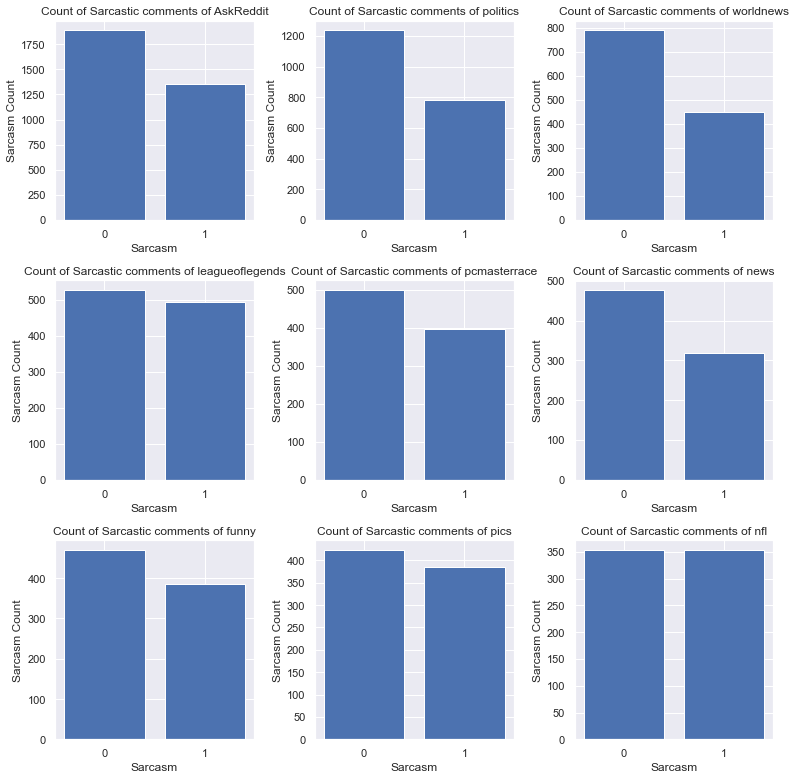

In [59]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('nfl')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "GlobalOffensive"')]

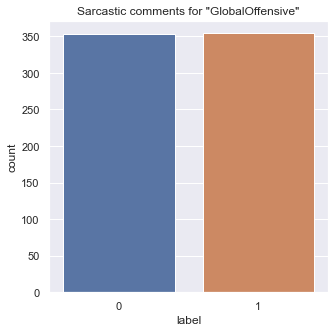

In [60]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "GlobalOffensive"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [61]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -96, while the highest one is 5818


In [62]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 "Suppression of dissent is about as facist as it gets"

 The Comment with the highest score is:
 lol, you can't make this stuff up.

 not sarcastic


In [63]:
red_sample.loc[red_sample['score'].idxmax()]

label                                                             0
comment                          lol, you can't make this stuff up.
author                                                StarkMidnight
subreddit                                           EnoughTrumpSpam
score                                                          5818
ups                                                              -1
downs                                                            -1
date                                                        2016-12
created_utc                                     2016-12-01 16:36:31
parent_comment    "Suppression of dissent is about as facist as ...
Name: 110228, dtype: object

In [64]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 The kind of repercussions I like to read of.

 The Comment with the lowest score is:
 Yeah because voting counts.

 sarcastic


In [65]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                        1
comment                            Yeah because voting counts.
author                                             -DocHopper-
subreddit                                             politics
score                                                      -96
ups                                                        -96
downs                                                        0
date                                                   2014-10
created_utc                                2014-10-03 12:48:34
parent_comment    The kind of repercussions I like to read of.
Name: 828426, dtype: object

Analysis on the scores

In [66]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

7.1293258671521 59.30206227720389


## Text analysis

In [67]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [68]:
red_copy.drop(['comment', 'author', 'score', 'ups', 'downs', 'date', 'created_utc'], axis=1, inplace=True)
red_copy.head(10)

,label,subreddit,parent_comment
546480,0,fo4,Question about physical copies and Steam So on...
725046,0,trees,Cream cheese dip! That's what lured me in...
301611,1,atheism,A Catholic mass murderer who repents will get ...
786533,1,starcraft,I'm just awestruck by that sick Protoss micro.
729510,1,DestinyTheGame,"I know! Can't we just be normal, rational peop..."
581318,0,GoneWildPlus,(F)irst post! I've been bursting to share with...
877074,1,wow,"But Draenei are. And I think they're here too,..."
263847,1,politics,More like 200-300 years ago during The Enlight...
38876,1,NASCAR,Sega releases first Teaser Trailer for Daytona...
189804,0,hiphopheads,I do


In [69]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,subreddit,parent_comment,char
546480,0,fo4,Question about physical copies and Steam So on...,286
725046,0,trees,Cream cheese dip! That's what lured me in...,44
301611,1,atheism,A Catholic mass murderer who repents will get ...,150
786533,1,starcraft,I'm just awestruck by that sick Protoss micro.,46
729510,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191


In [70]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

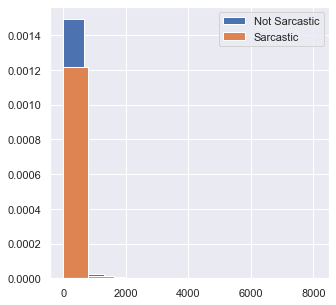

In [71]:
plotDistr('char')

In [72]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct
546480,0,fo4,Question about physical copies and Steam So on...,286,5
725046,0,trees,Cream cheese dip! That's what lured me in...,44,5
301611,1,atheism,A Catholic mass murderer who repents will get ...,150,3
786533,1,starcraft,I'm just awestruck by that sick Protoss micro.,46,2
729510,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191,7


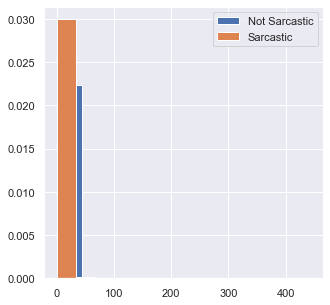

In [73]:
plotDistr('punct')

In [74]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens
546480,0,fo4,Question about physical copies and Steam So on...,286,5,59
725046,0,trees,Cream cheese dip! That's what lured me in...,44,5,8
301611,1,atheism,A Catholic mass murderer who repents will get ...,150,3,25
786533,1,starcraft,I'm just awestruck by that sick Protoss micro.,46,2,8
729510,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191,7,32


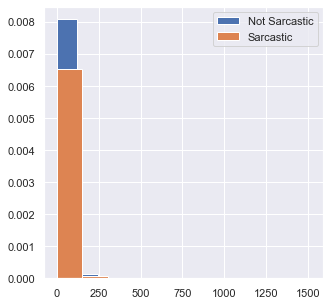

In [75]:
plotDistr('tokens')

In [76]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [77]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [78]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 4.0 minutes and 14.3 seconds


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

In [79]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens,clean
0,0,fo4,Question about physical copies and Steam So on...,286,5,59,question physic copi steam instal activ steam ...
1,0,trees,Cream cheese dip! That's what lured me in...,44,5,8,cream chees dip lure
2,1,atheism,A Catholic mass murderer who repents will get ...,150,3,25,cathol mass murder repent get buri cathol end ...
3,1,starcraft,I'm just awestruck by that sick Protoss micro.,46,2,8,awestruck sick protoss micro
4,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191,7,32,know ca normal ration peopl talk bug shit get ...


In [80]:
red_copy.rename(columns={'parent_comment':'parent'}, inplace=True)
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,0,fo4,Question about physical copies and Steam So on...,286,5,59,question physic copi steam instal activ steam ...
1,0,trees,Cream cheese dip! That's what lured me in...,44,5,8,cream chees dip lure
2,1,atheism,A Catholic mass murderer who repents will get ...,150,3,25,cathol mass murder repent get buri cathol end ...
3,1,starcraft,I'm just awestruck by that sick Protoss micro.,46,2,8,awestruck sick protoss micro
4,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191,7,32,know ca normal ration peopl talk bug shit get ...


Question about physical copies and Steam So once I've installed it and activated it with steam will I still need to have the disc in when I play it? The reason I ask is my disc drive is super noisy. And id rather nor have to take it in and out all the time (first world problems I know)


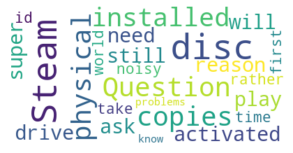

In [81]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_copy.parent[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [82]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['parent'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

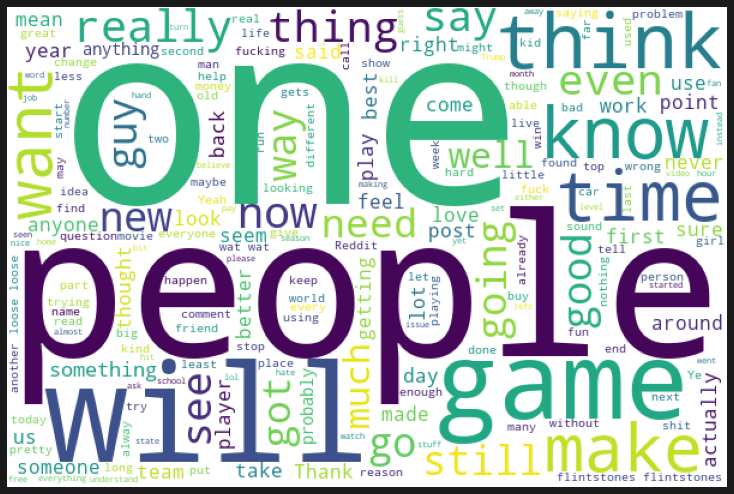

In [83]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

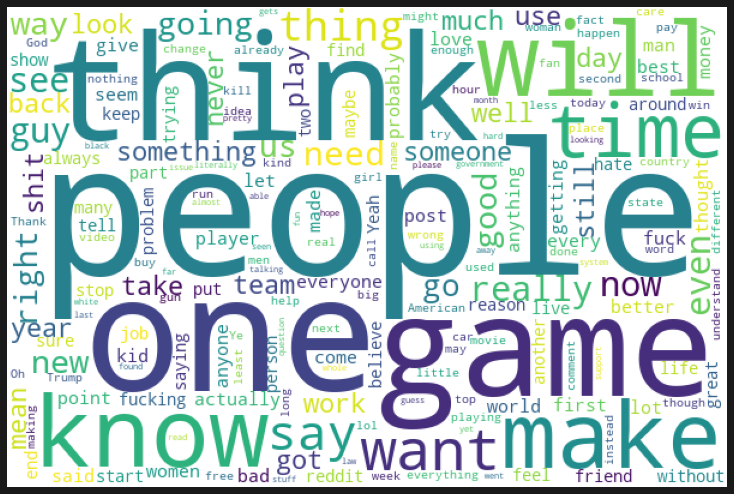

In [84]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [85]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['clean'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

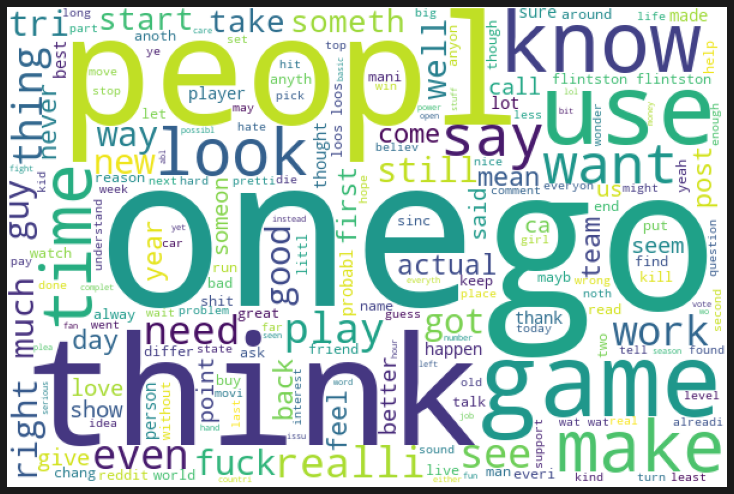

In [86]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

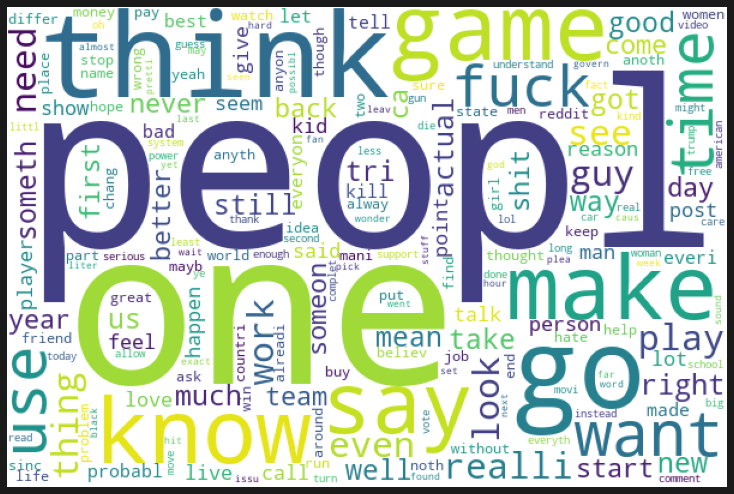

In [87]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [88]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

4068

In [89]:
X = red_copy[['clean','subreddit']]
y = red_copy['label']

In [90]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [91]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [92]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32344, 2)
(8087, 2)
(10108, 2)
(32344,)
(8087,)
(10108,)


In [93]:
red_train.head()

,clean,subreddit
20051,insan thresh play imaqtpi,leagueoflegends
12971,actual take back previous comment hope one hur...,news
41837,xbox one youtub app amaz comparison roku app s...,xboxone
19748,miss chanc ride one histor car gone red line,washingtondc
15527,want see donald trump unmask reveal garrosh face,wow


In [94]:
red_val.head()

,clean,subreddit
42280,nah stupid punt,gifs
45359,cat meme milit atheist pc snob titti girl next...,funny
34031,introduc new gf friend mean gf bisexu give loo...,AskReddit
33395,ok less resourc caus sponsor less inclin pay m...,KotakuInAction
29704,notebook xiaomi svelato full hd processor skyl...,italy


## Classification algorithms: First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. 

In [95]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2))
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [97]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [98]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [99]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [100]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [101]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

#### Naive Bayes

In [102]:
naive_bayes = NB.fit(reddit_train, y_train)

In [103]:
naiveBayes_predict = naive_bayes.predict(reddit_test)

In [104]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5721210922041947

Cross Validation:

In [105]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.55557273, 0.55974648, 0.56314732, 0.5697944 , 0.55735931])

#### Logistic Regression

In [106]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [107]:
## Fit the model
logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.1s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [108]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit.predict_proba(reddit_test)[:,1])

0.599638965535455

In [109]:
logit.predict_proba(reddit_test)[:,1]

array([0.34273562, 0.79371706, 0.48113056, ..., 0.35200839, 0.34948464,
       0.56743386])

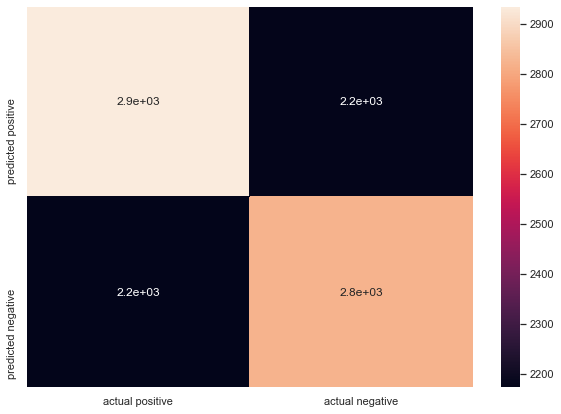

In [110]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, logit.predict(reddit_test)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True)
plt.show()

#### Random Forest

In [111]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest.fit(reddit_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [112]:
randomForest_predict = random_forest.predict(reddit_test)

In [113]:
metrics.accuracy_score(y_test, randomForest_predict)

0.5102888800949743

Cross Validation:

In [114]:
rf_cv = cross_val_score(random_forest, reddit_train, y_train, n_jobs = -1)
rf_cv

array([0.50162313, 0.50177771, 0.50579688, 0.50425104, 0.50355597])

### Let's try with a new sentence
We decided to try with two questions from AskReddit

In [115]:
sent1 = {'subreddit': ['AskReddit'], 'parent': ['What is your dream job? (Serious)']}
proof = pd.DataFrame(sent1)

In [116]:
proof

,subreddit,parent
0,AskReddit,What is your dream job? (Serious)


In [117]:
X_sub1 = subreddits_vectorizer.transform(proof['subreddit'])
X_parent1 = parent_vectorizer.transform(proof['parent'])
X_sent1 = hstack([X_sub1, X_parent1])

In [118]:
X_sent1

<1x305365 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in COOrdinate format>

In [119]:
NB.predict_proba(X_sent1)

array([[0.61144901, 0.38855099]])

In [120]:
logit.predict_proba(X_sent1)

array([[0.6302808, 0.3697192]])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [121]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,0,fo4,Question about physical copies and Steam So on...,286,5,59,question physic copi steam instal activ steam ...
1,0,trees,Cream cheese dip! That's what lured me in...,44,5,8,cream chees dip lure
2,1,atheism,A Catholic mass murderer who repents will get ...,150,3,25,cathol mass murder repent get buri cathol end ...
3,1,starcraft,I'm just awestruck by that sick Protoss micro.,46,2,8,awestruck sick protoss micro
4,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191,7,32,know ca normal ration peopl talk bug shit get ...


In [122]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,0,fo4,Question about physical copies and Steam So on...,286,5,59,question physic copi steam instal activ steam ...,question physic copi steam instal activ steam ...
1,0,trees,Cream cheese dip! That's what lured me in...,44,5,8,cream chees dip lure,cream chees dip lure trees
2,1,atheism,A Catholic mass murderer who repents will get ...,150,3,25,cathol mass murder repent get buri cathol end ...,cathol mass murder repent get buri cathol end ...
3,1,starcraft,I'm just awestruck by that sick Protoss micro.,46,2,8,awestruck sick protoss micro,awestruck sick protoss micro starcraft
4,1,DestinyTheGame,"I know! Can't we just be normal, rational peop...",191,7,32,know ca normal ration peopl talk bug shit get ...,know ca normal ration peopl talk bug shit get ...


In [123]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

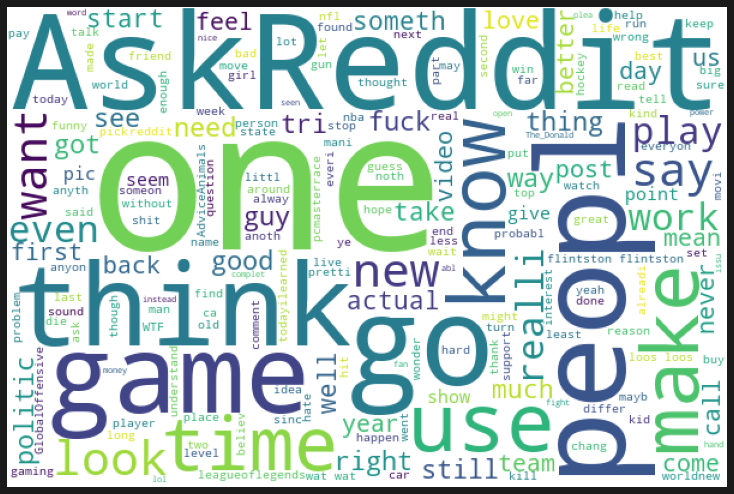

In [124]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

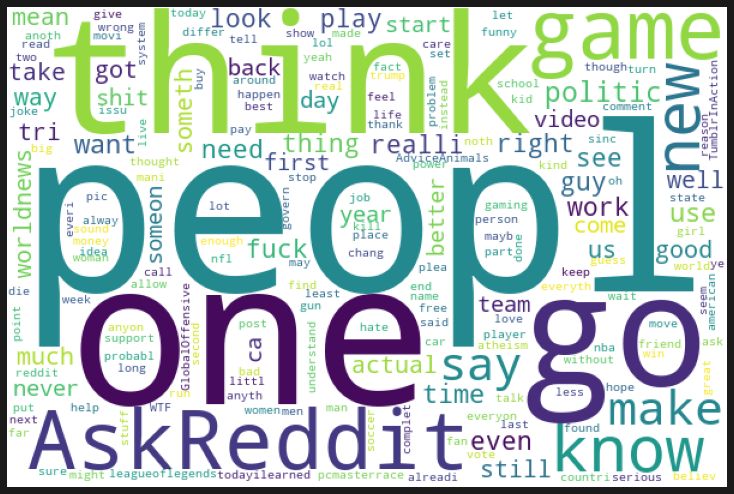

In [125]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [126]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [127]:
X2

,text
0,question physic copi steam instal activ steam ...
1,cream chees dip lure trees
2,cathol mass murder repent get buri cathol end ...
3,awestruck sick protoss micro starcraft
4,know ca normal ration peopl talk bug shit get ...
...,...
50534,keep busi card size give out peopl like tuck w...
50535,mayb peopl turn stupid name books
50536,take lap butler ca drop lol Patriots
50537,tahm kench river king avail leagueoflegends


In [128]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [129]:
clean_train2 = parent_vectorizer.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [130]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [131]:
naiveBayes_predict2 = naive_bayes2.predict(clean_test2)

In [132]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5710328452710725

Cross Validation:

In [133]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.56015828, 0.56183527, 0.56282464, 0.56331932, 0.55948553])

#### Random forest

In [134]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [135]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [136]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5070241392956074

Cross Validation:

In [137]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.50105107, 0.5054415 , 0.50247341, 0.50643087, 0.50234974])

#### Logistic Regression

In [138]:
X2 = red_copy['text']
y2 = red_copy['label']

In [139]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [140]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [141]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.8s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [142]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.5953816664876641

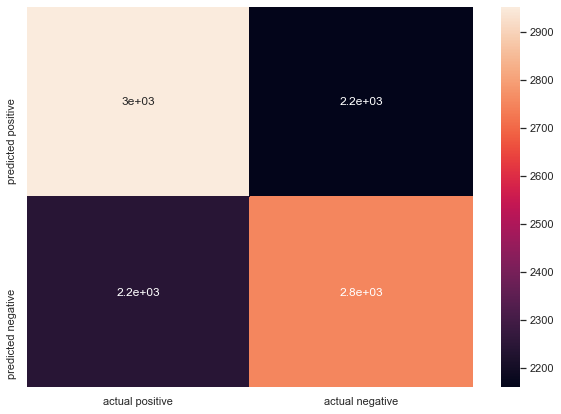

In [143]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

### Let's make an example

In [144]:
sent2 = {'text': ['AskReddit: What is your dream job? (Serious)']}
proof2 = pd.DataFrame(sent2)

In [145]:
proof2

,text
0,AskReddit: What is your dream job? (Serious)


In [146]:
X_parent2 = parent_vectorizer.transform(proof2['text'])

In [147]:
naive_bayes2.predict_proba(X_parent2)

array([[0.42555659, 0.57444341]])

In [148]:
X_parent2 = tf_idf2.transform(proof2['text'])

In [149]:
logit.predict_proba(X_parent2)

array([[0.40144812, 0.59855188]])

#### GridSeachCV:

In [150]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [151]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [152]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.1s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [153]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [154]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 56.41% 



## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [155]:
category = red_copy['subreddit'].astype('category').cat.categories.tolist()
replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [156]:
red_copy.replace(replace_sub, inplace=True)

In [157]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,0,2690,Question about physical copies and Steam So on...,286,5,59,question physic copi steam instal activ steam ...,question physic copi steam instal activ steam ...
1,0,3872,Cream cheese dip! That's what lured me in...,44,5,8,cream chees dip lure,cream chees dip lure trees
2,1,2141,A Catholic mass murderer who repents will get ...,150,3,25,cathol mass murder repent get buri cathol end ...,cathol mass murder repent get buri cathol end ...
3,1,3713,I'm just awestruck by that sick Protoss micro.,46,2,8,awestruck sick protoss micro,awestruck sick protoss micro starcraft
4,1,542,"I know! Can't we just be normal, rational peop...",191,7,32,know ca normal ration peopl talk bug shit get ...,know ca normal ration peopl talk bug shit get ...


In [158]:
## TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(red_copy["clean"])
print(R.shape)
type(R)

(50539, 34206)


scipy.sparse.csr.csr_matrix

In [159]:
#L = vectorizer.fit_transform(red_copy["subreddit"])
#print(R.shape)
#type(R)

In [160]:
# We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

In [161]:
R = addFeature(R, red_copy['subreddit'])

In [162]:
print(R.shape)

(50539, 34207)


In [163]:
features = np.append(vectorizer.get_feature_names(), ['Sub'])

In [164]:
features

array(['aa', 'aaa', 'aaaand', ..., 'zoom', 'zuckerberg', 'Sub'],
      dtype='<U20')

In [165]:
y_label = red_copy['label']

In [166]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20) 
R_new = selector.fit_transform(R, y_label)
print(R_new.shape)

(50539, 20)


In [167]:
features[selector.get_support()]

array(['cat', 'children', 'conspiraci', 'immigr', 'law', 'male', 'men',
       'muslim', 'peopl', 'racist', 'rape', 'sarcasm', 'sarcast',
       'sexist', 'sexual', 'thank', 'white', 'woman', 'women', 'Sub'],
      dtype='<U20')

In [168]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(R,y_label)
score = list(zip(features, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('Sub', 58349.67110147211, 0.0),
 ('thank', 19.683360675517328, 9.139370537051568e-06),
 ('sarcasm', 18.64048377037304, 1.5783310293513128e-05),
 ('women', 18.051285525279688, 2.1503340015381302e-05),
 ('peopl', 17.60654804526593, 2.7165138306669043e-05),
 ('racist', 15.455170444188727, 8.448549627921704e-05),
 ('rape', 14.50486496771126, 0.00013979804410898966),
 ('men', 14.404482291282502, 0.0001474509212398321),
 ('sarcast', 9.952503230797504, 0.0016063083022656674),
 ('children', 9.84435706846716, 0.0017035352022935072),
 ('woman', 9.134924090927475, 0.002507758649314886),
 ('sexual', 8.302858292238756, 0.003958273258624983),
 ('immigr', 8.148981848178828, 0.004308534449438751),
 ('sexist', 7.650164935477279, 0.005676713102987662),
 ('white', 7.631383538174053, 0.005736128408288454),
 ('muslim', 7.605309207685551, 0.005819668321765466),
 ('cat', 7.072520904793249, 0.007827504743671011),
 ('law', 7.068020999367863, 0.00784718839739852),
 ('conspiraci', 6.7484274928528905, 0.0093830

In [169]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
R_sel = R[:,sel]
features_sel = features[sel]
R_sel

<50539x20 sparse matrix of type '<class 'numpy.float64'>'
	with 58525 stored elements in Compressed Sparse Row format>

In [170]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_scale = scaler.fit_transform(R_sel.toarray())

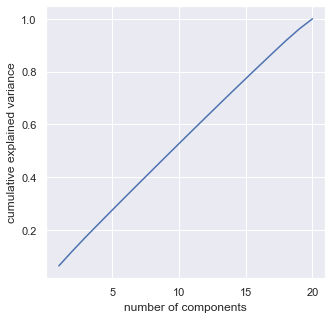

In [172]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(R_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()